#HW 7

# Домашнее задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

---

In [1]:
# Загрузка библиотек

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

In [2]:
# Параметры

max_words = 2000
max_len = 10
num_classes = 1

# Training

epochs = 25
batch_size = 512
print_batch_n = 100

In [3]:
# Загрузка данных

from google.colab import drive
drive.mount('/content/drive')

train_csv = '/content/drive/My Drive/Twitter Sentiment Analysis/train.csv'
test_csv = '/content/drive/My Drive/Twitter Sentiment Analysis/test.csv'

Mounted at /content/drive


---

In [4]:
# Создание df

df = pd.read_csv(train_csv)
df_train , df_val = df[:25000].copy(), df[25001:].copy()
df_test = pd.read_csv(test_csv)

# Проверка

df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# Установка pymorphy2

!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 8.2 MB 40.6 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=84973604ab142be55e47740c64edd93ca43c658a4f4db0fdec77bcc7d378dbd1
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [6]:
# Загрузка дополнительных библиотек

from string import punctuation
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
import re

In [7]:
# sw, puncts

sw = set(get_stop_words("en"))
puncts = set(punctuation)

In [8]:
# nltk

import nltk
nltk.download('wordnet')
  
morpher = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [9]:
# Функция preprocess

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [10]:
# tqdm

from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 6961/6961 [00:00<00:00, 18593.76it/s]


In [11]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['user', 'father', 'dysfunctional', 'selfish', 'drag']

In [12]:
# Наиболее частые токены

from nltk.probability import FreqDist

tokens_filtered = [word for word in tokens if word.isalnum()]

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [13]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [14]:
# Функция text_to_sequence

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [15]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 4.09 s, sys: 3.42 ms, total: 4.09 s
Wall time: 4.16 s


In [16]:
# class GRUFixedLen

from torch import nn

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [17]:
# class DataWrapper

from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [18]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [19]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [21]:
# Model

gru_init = gru_init.to(device)
gru_init.train()
th = 0.4

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/25]. Step [49/49]. Loss: 0.302. Acc: 0.473. Test loss: 0.240. Test acc: 0.930
Epoch [2/25]. Step [49/49]. Loss: 0.233. Acc: 0.931. Test loss: 0.082. Test acc: 0.935
Epoch [3/25]. Step [49/49]. Loss: 0.209. Acc: 0.937. Test loss: 0.050. Test acc: 0.941
Epoch [4/25]. Step [49/49]. Loss: 0.187. Acc: 0.945. Test loss: 0.378. Test acc: 0.947
Epoch [5/25]. Step [49/49]. Loss: 0.157. Acc: 0.949. Test loss: 0.029. Test acc: 0.945
Epoch [6/25]. Step [49/49]. Loss: 0.192. Acc: 0.951. Test loss: 0.015. Test acc: 0.948
Epoch [7/25]. Step [49/49]. Loss: 0.157. Acc: 0.954. Test loss: 0.057. Test acc: 0.948
Epoch [8/25]. Step [49/49]. Loss: 0.130. Acc: 0.956. Test loss: 0.010. Test acc: 0.949
Epoch [9/25]. Step [49/49]. Loss: 0.141. Acc: 0.958. Test loss: 0.012. Test acc: 0.950
Epoch [10/25]. Step [49/49]. Loss: 0.112. Acc: 0.960. Test loss: 0.112. Test acc: 0.949
Epoch [11/25]. Step [49/49]. Loss: 0.155. Acc: 0.962. Test loss: 0.005. Test acc: 0.948
Epoch [12/25]. Step [49/49]. Loss: 0.094.

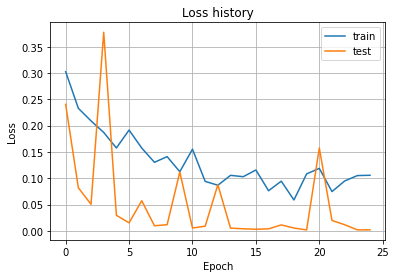

In [22]:
# Plot

import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();